<a href="https://colab.research.google.com/github/crazycloud/dl-blog/blob/master/2020_03_18_Transformers_Multihead_Self_Attention_Explanation_%26_Implementation_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Multihead Self Attention in Transformers with simple Pytorch Implementation"
> Learn about Self Attention, the basic building block of Transformer architecture - With a simple pytorch Implementation

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [nlp, transformers, self attention]
- hide: false

##  Multihead self attention in Transformers

**What is self attention?**

**Sequential models** like RNN & LSTM generate the token representation based on information carried forward from previous tokens. This way a token captures the contextual information about previous words. It works sequentially, i.e., each token representation has to be calculated in the sequential order because of the dependency on previous tokens representation. 

**Self Attention** is another way to generate contextual representation of a token and it works by calculating similarity score(attention score) between the current token and rest of the tokens to assign attention weights to each token in a sequence.  Attention score dictactes how much to attend to the neighbouring words.

> Attention weight/score of a token= scaled dot product of a token vector and rest of the token vectors  

> New Token vector = Weighted sum of other token vectors  

The advantage of Self attention is that we can caculate the token representations parallely for each token.


X is the sequence with x1...xt tokens

h is the new token representation. The average is weighted by attention scores of corresponding words.

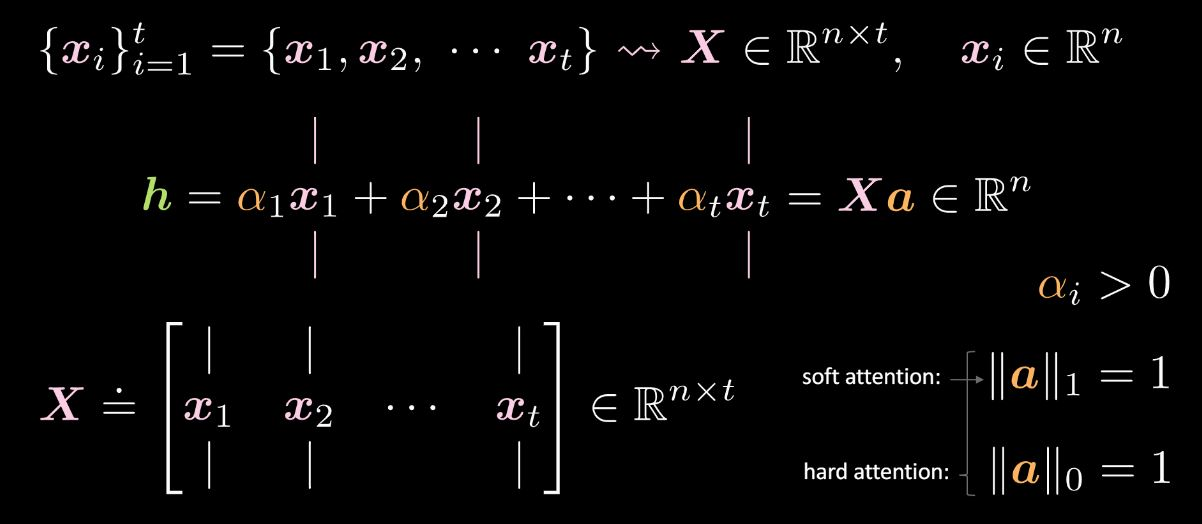

Source [Deep Learning Course](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/slides/10%20-%20Attention%20%26%20transformer.pdf)

Following the paradigm of Information Retrieva(IR), the transformer model transforms each token input x1 into three vectors key, query and value.

Like in IR problem, the Key vector of a token are used to find similarity with other tokens Query vectors, and corresponding Value vectors are used weighted based on the attention scores.

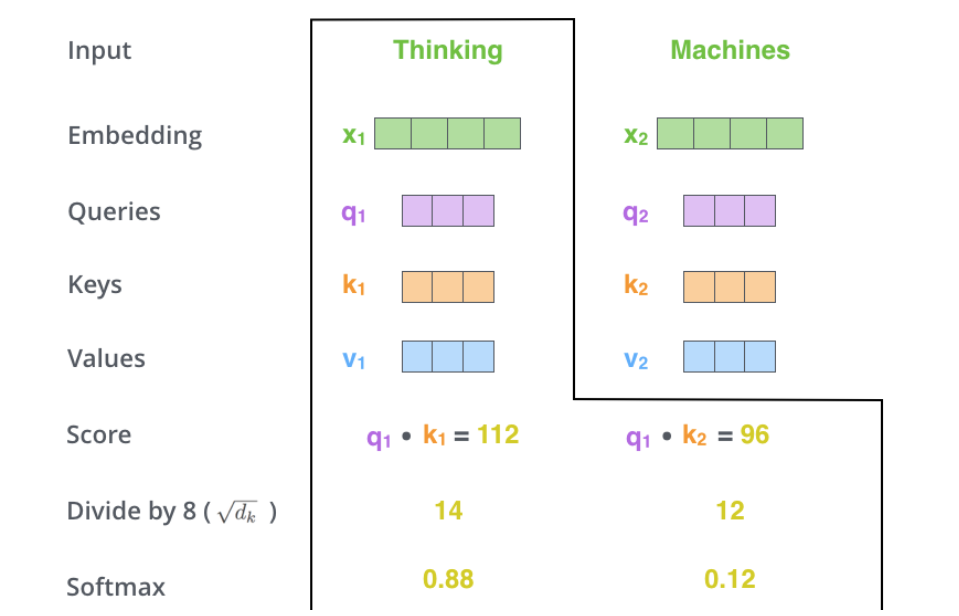

Source [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)

## Implement Self Attention in Pytorch

Let us implement the self attention module in Pytorch. I find it easy to understand the torch operations better using the tensor shapes. 

We will check each opeartion one by one for simplicity

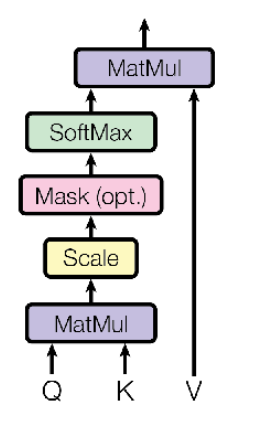

In [1]:
import torch
import torch.nn as nn

E - embedding dim   
The word embedding dimension and also the dimension for each key, value and query vectors. We assume each word is a E dimension vector and we use a Linear Layer to Transform the token vector in to K, V, Q vector of E dimension. The reason to transform it into E dimension is related to Multiheads where we calculate attention for multiple heads. We will add the multihead after implementing a simple self attention module


T - Seq Length  
Maximum Numbers of words to process at a time

In [66]:
T = 5 #5 words sequence/Timesteps
E = 768 #word embedding

In [67]:
#generate random sample data
x = torch.randn(T,E) # (T,E)
x.shape

torch.Size([5, 768])

We will ignore the Batch dimension for now. If we consider batch dimension as well the input will be of format (N T E) instead of (T E)

Transform input sequence X into [key, query, value] of the same embedding dimension E   
x - > q, k, v

A 768 vector x1 will be transformed into three 768 vectors K,V,Q

In [68]:
query = nn.Linear(E, E) 
key = nn.Linear(E, E)
val = nn.Linear(E, E)

q = query(x) # (T,E)
k = key(x) # (T,E)
v = val(x) # (T,E)

In [69]:
print(q.shape,k.shape, v.shape)

torch.Size([5, 768]) torch.Size([5, 768]) torch.Size([5, 768])


Once we have the K, V, Q vectors, we can calculate the attention scores using the scaled dot product

In [70]:
import math
mat_mul = q @ k.transpose(-1,-2) #(T, E) (E, T) --> (T,T)
att = mat_mul/math.sqrt(k.size(-1))

In [71]:
att.shape # (T,T)

torch.Size([5, 5])

In [72]:
att

tensor([[-0.0331, -0.4722, -0.6780,  0.7257, -0.2618],
        [-0.2122, -0.2950, -0.2698, -0.4904,  0.4189],
        [ 0.0623,  0.0334, -0.3229,  0.0644, -0.3275],
        [ 0.2513, -0.2484, -0.7515, -0.0530,  0.1738],
        [-0.6862, -0.4833,  0.3588, -0.0983, -0.0572]], grad_fn=<DivBackward0>)

## Visualize Attention Weights 
Let us plot attention scores

In [73]:
import seaborn as sns
import numpy as np
def plot(attention_scores):
  sns.set_theme()
  ax = sns.heatmap(attention_scores.cpu().detach().numpy(), xticklabels=['w1','w2','w3','w4','w5'],  yticklabels=['w1','w2','w3','w4','w5'])

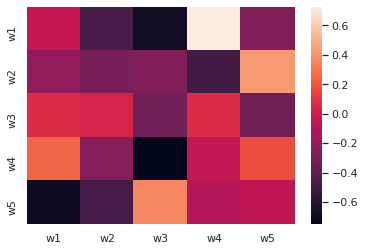

In [74]:
plot(attention_scores = att)

To convert all attention scores into probability, we run it through a softmax function. It normalizes the attention scores

In [75]:
from torch.nn import functional as F
att = F.softmax(att, dim=-1)

In [76]:
att

tensor([[0.1961, 0.1264, 0.1029, 0.4187, 0.1560],
        [0.1818, 0.1673, 0.1716, 0.1376, 0.3417],
        [0.2309, 0.2243, 0.1571, 0.2314, 0.1564],
        [0.2750, 0.1668, 0.1009, 0.2028, 0.2545],
        [0.1144, 0.1401, 0.3252, 0.2059, 0.2145]], grad_fn=<SoftmaxBackward>)

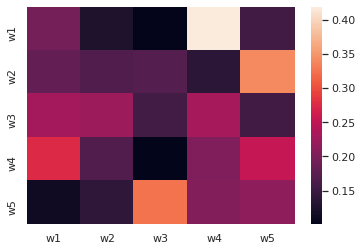

In [77]:
plot(attention_scores = att)

Attention scores can be interpreted as the weight given to other words for calculating the representation of a word. The puple/black color boxes represent higher weights for those words.


Calculate the new token representation by taking attention weighted average for each input xi

In [78]:
h = att @ v

In [79]:
h.shape

torch.Size([5, 768])

## Complete Code for SelfAttention Module 

In [82]:
class SelfAttention(nn.Module):
  def __init__(self, E):
    super().__init__()
    query = nn.Linear(E, E) 
    key = nn.Linear(E, E)
    val = nn.Linear(E, E)

  def forward(self, x):
    q = query(x) # (T,E)
    k = key(x) # (T,E)
    v = val(x) # (T,E)

    mat_mul = q @ k.transpose(-1,-2) #(T, E) (E, T) --> (T,T)
    att = mat_mul/math.sqrt(k.size(-1)) 
    att = F.softmax(att, dim=-1)
    h = att @ v

    return h, att

In [83]:
att = SelfAttention(E)
h, attention_scores = att(x)

## Implement Multihead Self Attention

Multihead Self attention divides the key, query and value Nh heads. The reason is that emperically it has been found that each head attends to a different property of input vector.

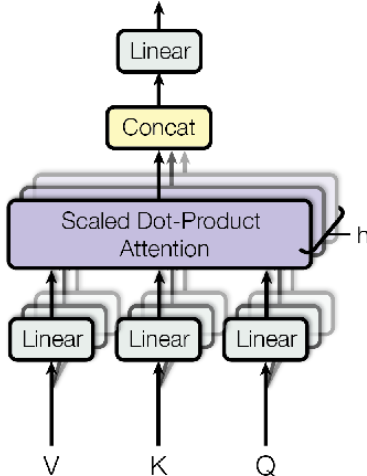


We logically divide each Q, K, V vector into Multiple Heads - Nh

Let us say number of heads Nh = 12

Q vector 768 dim is divided into 768/12 = 64  
single head dimension Eh = 64

Q = Q1 Q2 .. Qnh

where Q1 has shape (T, Nh, Eh)

we swap Q1 to get (T, Eh) in last dimension. We don't split any of the vectors to create a new vector. The operations are efficiently performed in a single matrix by seperating the dimensions.

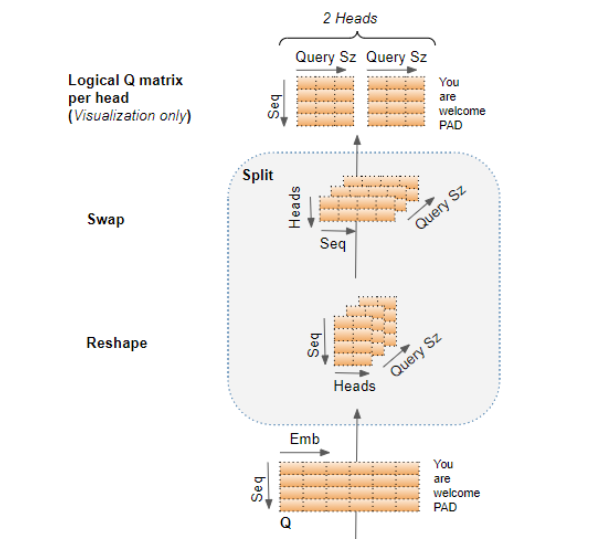


Source - [Medium Article](https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853)

In [84]:
class MultiheadSelfAttention(nn.Module):
  def __init__(self, E, Nh):
    super().__init__()
    query = nn.Linear(E, E) 
    key = nn.Linear(E, E)
    val = nn.Linear(E, E)
    self.Nh = Nh

  def forward(self, x):
    T,E = x.size()
    q = query(x).view(T, self.Nh, E // self.Nh) # (T, Nh, Eh)
    q = q.transpose(0,1) #(Nh,T, Eh)

    k = query(x).view(T, self.Nh, E // self.Nh) # (T, Nh, Eh)
    k = k.transpose(0,1) #(Nh,T, Eh)
    
    v = query(x).view(T, self.Nh, E // self.Nh) # (T, Nh, Eh)
    v = v.transpose(0,1) #(Nh,T, Eh)

    mat_mul = q @ k.transpose(-1,-2) #(Nh,T, Eh) (Nh, Eh, T) --> (Nh, T, T)
    att = mat_mul/math.sqrt(k.size(-1)) 
    att = F.softmax(att, dim=-1) #(Nh, T, T)
    h = att @ v # (Nh, T, T) (Nh, T, Eh) -->  (Nh, T, Eh)

    # concatenate all heads 
    h = h.transpose(0,1) #(T, Nh, Eh)
    h = h.contiguous().view(T, E) #(T, Nh, Eh) => (T, E)
    return h, att

In [86]:
att = MultiheadSelfAttention(768,12)
h, attention_scores = att(x)

## Pytorch Built-in MultiHeadAttention module

Pytorch has a built in module for multihead attention that takes as input the key, query and value vectors

In [92]:
multihead_attn = nn.MultiheadAttention(E, num_heads=12)

x = torch.randn(5,1, 768) # (T B E)

query = nn.Linear(E, E) 
key = nn.Linear(E, E)
val = nn.Linear(E, E)

q = query(x) # (T B E)
k = key(x) # (T B E)
v = val(x) # (T B E)

attn_output, attn_output_weights = multihead_attn(q, k, v)

In [93]:
attn_output.shape # (T B E)

torch.Size([5, 1, 768])

In [94]:
attn_output_weights.shape # (B T T)


torch.Size([1, 5, 5])

The Bert and GPT architecture uses 12 attention heads and embedding dimension of 768.Transformers architecture uses multiple layers of multihead self attention to transform input in to final representation for a token.

In the next post we will build on top of it to create the transformer block which uses multi headed self attention, residual block and position-wise feed forward network.